In [33]:
%config InlineBackend.figure_formats = ['retina']
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 125
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from time import time
from random import random, seed
from functools import partial
from collections import defaultdict
from networkx.algorithms.distance_measures import diameter
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from wasserplan import Pair, UnbalancedPair

In [2]:
seed(50)
np.random.seed(50)

In [3]:
graph = Graph.from_json("pa_json.json")

In [4]:
my_updaters = {"population": updaters.Tally("TOT_POP", alias="population")}

In [5]:
initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)

In [6]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
proposal = partial(recom,
                   pop_col="TOT_POP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
)

In [7]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

## Sampling methodology

We sample two partitions, we run a ReCom chain on Pennsylvania for 100 steps, using the 2011 plan as the seed plan. We compare district 1 in the first plan sampled ("plan A") with district 1 in the last plan sampled ("plan B"). To compute unbalanced distances, we use $\lambda$-values $\{0, 2, 4, \ldots, 48\}$. (Note that computing plan-level distances is very computationally expensive.)

In [8]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=100
)

In [9]:
partitions = [part for part in chain]

In [10]:
# For all experiments, we fix a partition A and a partition B.
part_a = partitions[0]
part_b = partitions[-1]

In [11]:
# We also fix district indices within these partitions.
part_a_district = 10
part_b_district = 10

In [12]:
total_costs = []
total_slack_costs = []
total_flow_costs = []
times = []
lambda_vals = [x / 2 for x in range(100)]
for lambda_val in lambda_vals:
    unbalanced_pair = UnbalancedPair(part_a,
                                     part_b,
                                     indicator='population',
                                     pop_col='TOT_POP',
                                     slack_norm=1,
                                     slack_lambda=lambda_val)
    tik = time()
    cost, slack, flow = unbalanced_pair._district_distance(part_a_district,
                                                           part_b_district)
    tok = time()
    total_costs.append(cost)
    total_slack_costs.append(lambda_val * np.sum(np.abs(slack)))
    total_flow_costs.append(np.sum(np.abs(flow)))
    times.append(tok - tik)

In [13]:
balanced_pair = Pair(partitions[0],
                     partitions[-1],
                     indicator='population',
                     pop_col='TOT_POP')
balanced_cost = balanced_pair.district_distance(1, 1)

## Population weighting

In the balanced case, indicator vectors for partitions are normalized such that $\|x\|_1 = 1$ for any indicator vector $x \in \mathbb{R}^{|V|}$. For a partition $P$ with indicator vector $x$, $x_i = \frac{\text{population}(v_i)}{\sum_{v \in P} \text{population}(v)}$ if $v_i \in P$; $x_i = 0$ otherwise.

In the balanced case, indicator vectors are normalized with respect to the target district population, such that if partition $P$ with indicator vector $x$ exceeds the population tolerance by some proportion $\epsilon$, then $\|x\|_1 = 1 + \epsilon$. For target district population $T$, $x_i = \frac{\text{population}(v_i)}{T}$ if $v_i \in P$; $x_i = 0$ otherwise.

In [14]:
b_plan_a = balanced_pair._a_indicators[0]  # indicators are 0-indexed, not 1-indexed!
b_plan_b = balanced_pair._b_indicators[0]
print('[Balanced] Mass of district 1 indicator vector in plan A: {:.4f}'.format(np.sum(b_plan_a)))
print('[Balanced] Mass of district 1 indicator vector in plan B: {:.4f}'.format(np.sum(b_plan_b)))

[Balanced] Mass of district 1 indicator vector in plan A: 1.0000
[Balanced] Mass of district 1 indicator vector in plan B: 1.0000


In [15]:
ub_plan_a = unbalanced_pair._a_indicators[0]  # indicators are 0-indexed, not 1-indexed!
ub_plan_b = unbalanced_pair._b_indicators[0]
print('[Unbalanced] Mass of district 1 indicator vector in plan A: {:.4f}'.format(np.sum(ub_plan_a)))
print('[Unbalanced] Mass of district 1 indicator vector in plan B: {:.4f}'.format(np.sum(ub_plan_b)))

[Unbalanced] Mass of district 1 indicator vector in plan A: 1.0012
[Unbalanced] Mass of district 1 indicator vector in plan B: 0.9908


## Results

### Total distance
As shown in the figure below, small $\lambda$-values encourage a slack vector ($z$) with a relatively large 1-norm in exchange for less flow, while high $\lambda$-values encourage more flow and a slack vector with a relatively small 1-norm.

In [16]:
# Bounds for pretty plots
x_min = min(lambda_vals) - 2
x_max = max(lambda_vals) + 2

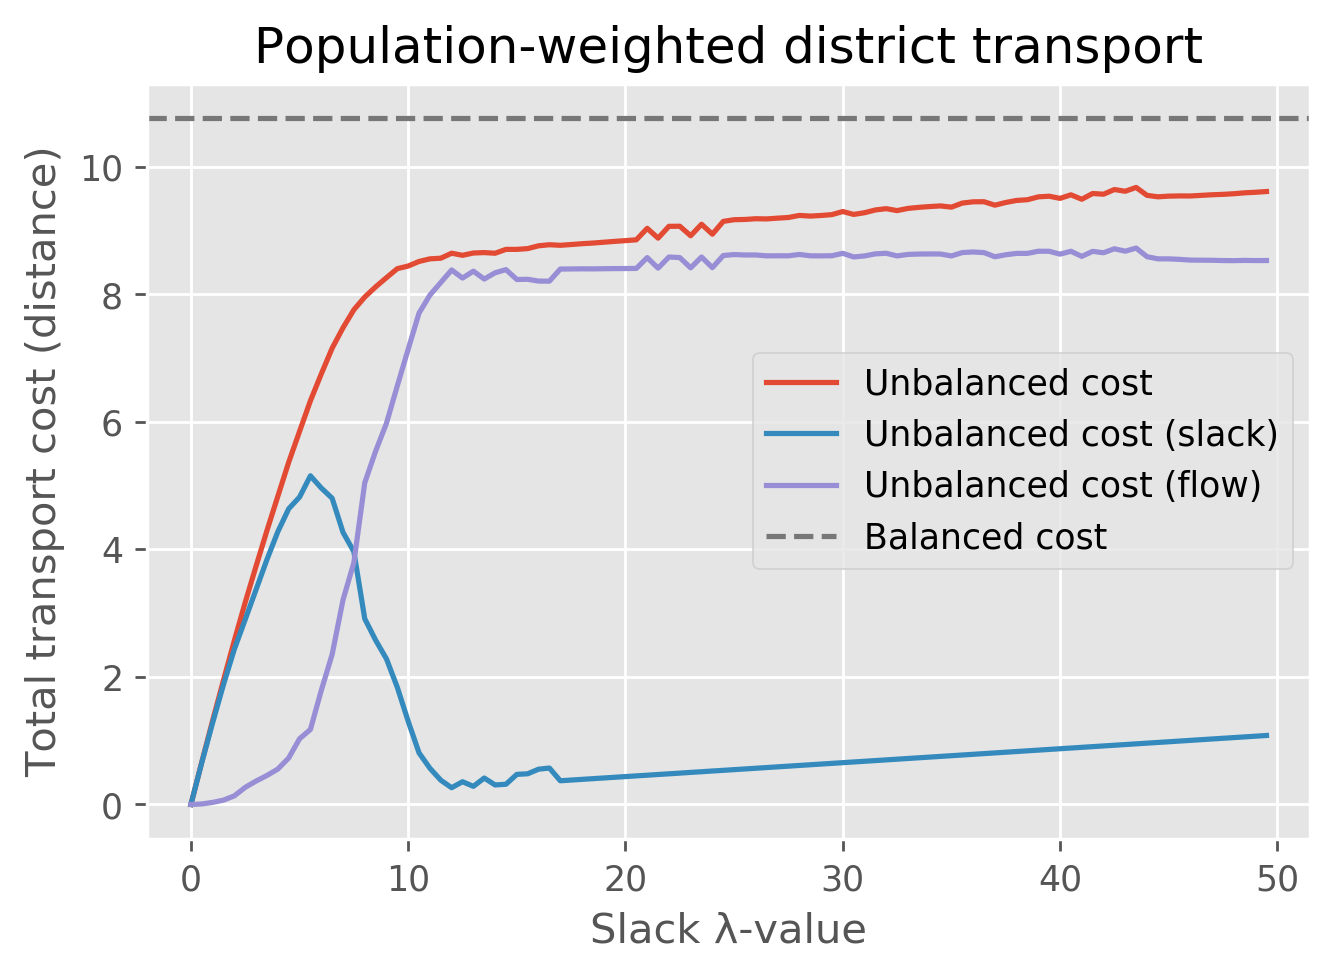

In [34]:
plt.title('Population-weighted district transport')
plt.plot(lambda_vals, total_costs, label='Unbalanced cost')
plt.plot(lambda_vals, total_slack_costs, label='Unbalanced cost (slack)')
plt.plot(lambda_vals, total_flow_costs, label='Unbalanced cost (flow)')
plt.plot([x_min, x_max], [balanced_cost, balanced_cost], '--', label='Balanced cost')
plt.xlabel('Slack λ-value')
plt.ylabel('Total transport cost (distance)')
plt.xlim(x_min, x_max)
plt.legend()
plt.savefig('transport_cost_vs_lambda.png', bbox_inches='tight', dpi=300)
plt.show()

### Monotonicity
We expect total distance to increase monotonically in $\lambda$ (see proposition 6.4). Thus, for two distances between the same pair of graph partitions, a positive difference in $\lambda$-value implies a positive difference in distance.

This property does not always hold in practice, implying that there may be notable error in the solutions found by the solver.

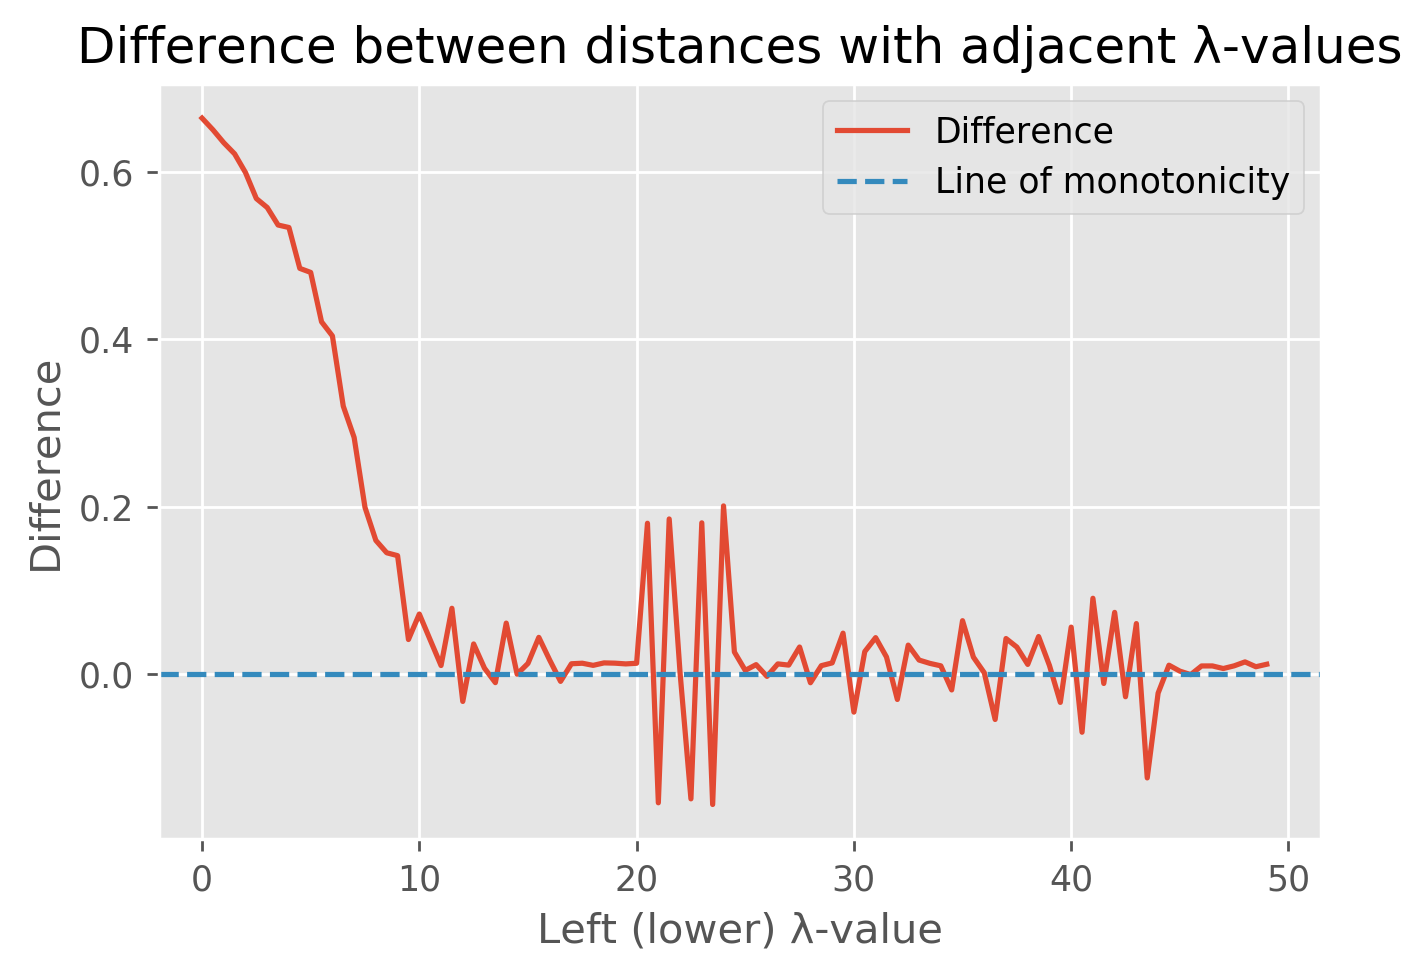

In [35]:
distance_deltas = np.array(total_costs[1:]) - np.array(total_costs[:-1])
plt.title('Difference between distances with adjacent λ-values')
plt.xlabel('Left (lower) λ-value')
plt.ylabel('Difference')
plt.plot(lambda_vals[:-1], distance_deltas[:], label='Difference')
plt.plot([x_min, x_max], [0, 0], '--', label='Line of monotonicity')
plt.legend()
plt.xlim(x_min, x_max)
plt.savefig('monotonicity_lambda.png', bbox_inches='tight', dpi=300)
plt.show()

### Runtime
We might consider runtime to be a rough proxy for the difficulty of distance calculations. For instance, note that in the degenerate case ($\lambda = 0$), the optimization problem is simplified and the runtime is shortened accordingly.

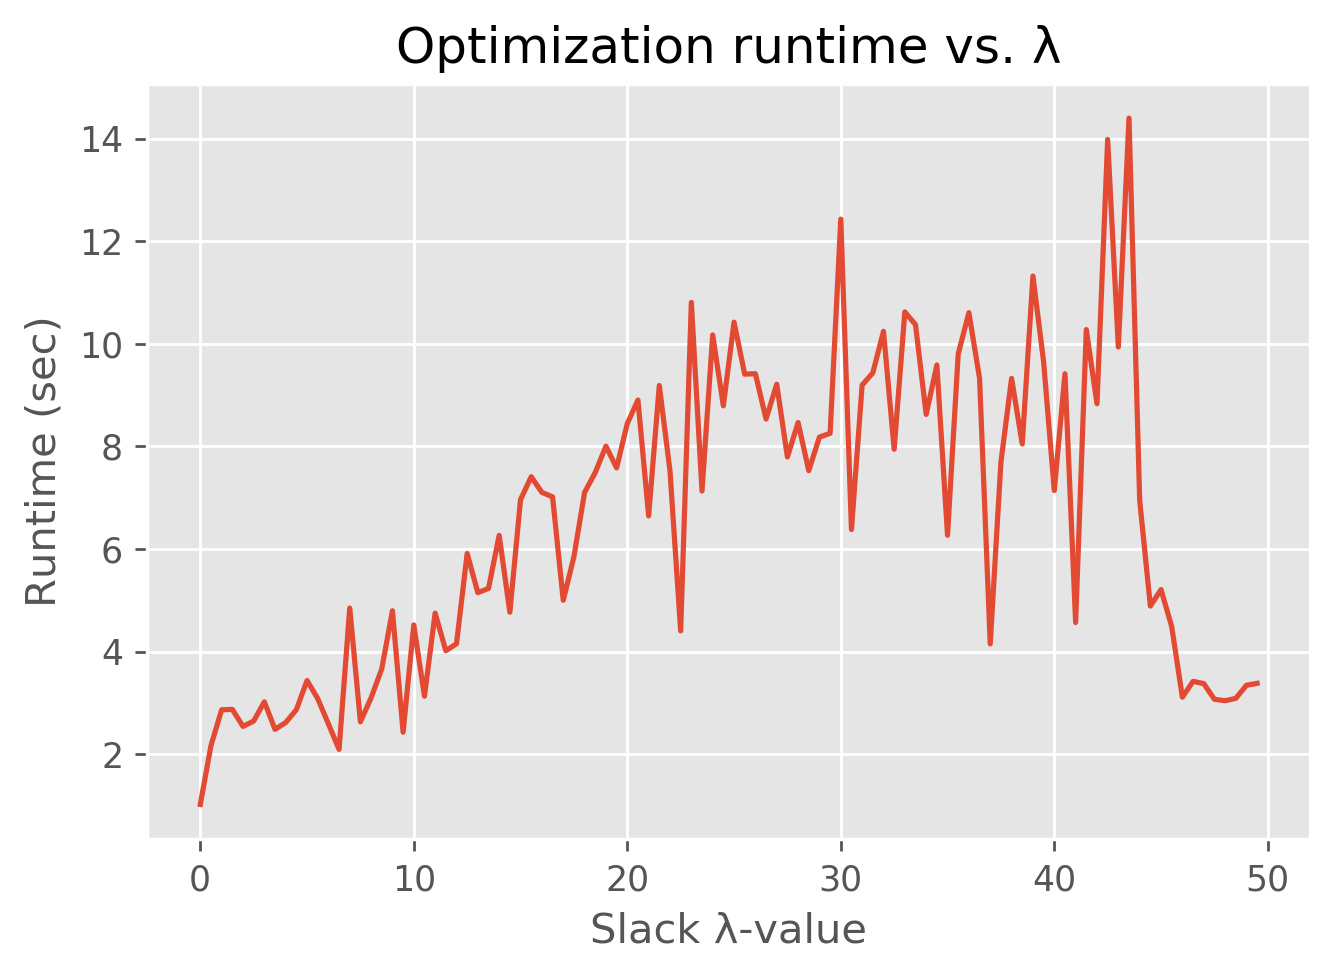

In [36]:
plt.title('Optimization runtime vs. λ')
plt.plot(lambda_vals, times)
plt.xlabel('Slack λ-value')
plt.ylabel('Runtime (sec)')
plt.savefig('runtime_vs_lambda.png', bbox_inches='tight', dpi=300)
plt.show()

### Visual flow
Optimal solutions to the transport between partitions problem generally utilize a small subset of paths in the graph. We can visualize these paths by coloring each node by the total amount of flow across it.

In [20]:
# Pennsylvania is split between UTM zones 17N and 18N.
gdf = gpd.read_file("./PA_VTD/PA_VTD.shp").to_crs('+proj=utm +zone=17N +ellps=WGS84 '
                                                  '+datum=WGS84 +units=m +no_defs')

In [46]:
def plot_flows(part_a, part_b, part_a_district, part_b_district, slack_lambda=20, dpi=100):
    """Plots the flow between two districts (graph partitions)."""
    # Calculate the flow.
    unbalanced_pair = UnbalancedPair(part_a,
                                     part_b,
                                     indicator='population',
                                     pop_col='TOT_POP',
                                     slack_norm=1,
                                     slack_lambda=slack_lambda)
    _, _, flow = unbalanced_pair._district_distance(part_a_district, 
                                                    part_b_district)    
    flow = np.abs(flow)
    edges = list(graph.edges)
    node_flow = defaultdict(float)
    for flow_idx, edge in enumerate(edges):
        left_node, right_node = edge
        node_flow[left_node] += flow[flow_idx]
        node_flow[right_node] += flow[flow_idx]
        
    # Plot partition A.
    gdf['part'] = [1 if idx in part_a.parts[part_a_district] else 0
                   for idx in range(len(part_a.graph.nodes))]
    gdf.plot(column='part')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'District {part_a_district} in partition A')
    plt.savefig(f'a_{part_a_district}.png', bbox_inches='tight', dpi=dpi)
    plt.show()
    
    # Plot partition B.
    gdf['part'] = [1 if idx in part_b.parts[part_b_district] else 0
                   for idx in range(len(part_b.graph.nodes))]
    gdf.plot(column='part')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'District {part_b_district} in partition B')
    plt.savefig(f'b_{part_b_district}.png', bbox_inches='tight', dpi=dpi)
    plt.show()
    
    # Plot the flow.
    flow_sorted = [f[1] for f in sorted(node_flow.items(), key=lambda kv: kv[0])]
    gdf['flow'] = flow_sorted
    gdf.plot(column='flow', legend=True)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Node flow (Dist. {part_a_district} in A → dist. {part_b_district} in B)')
    plt.savefig(f'flow_{part_a_district}_{part_b_district}.png', bbox_inches='tight', dpi=dpi)
    plt.show()

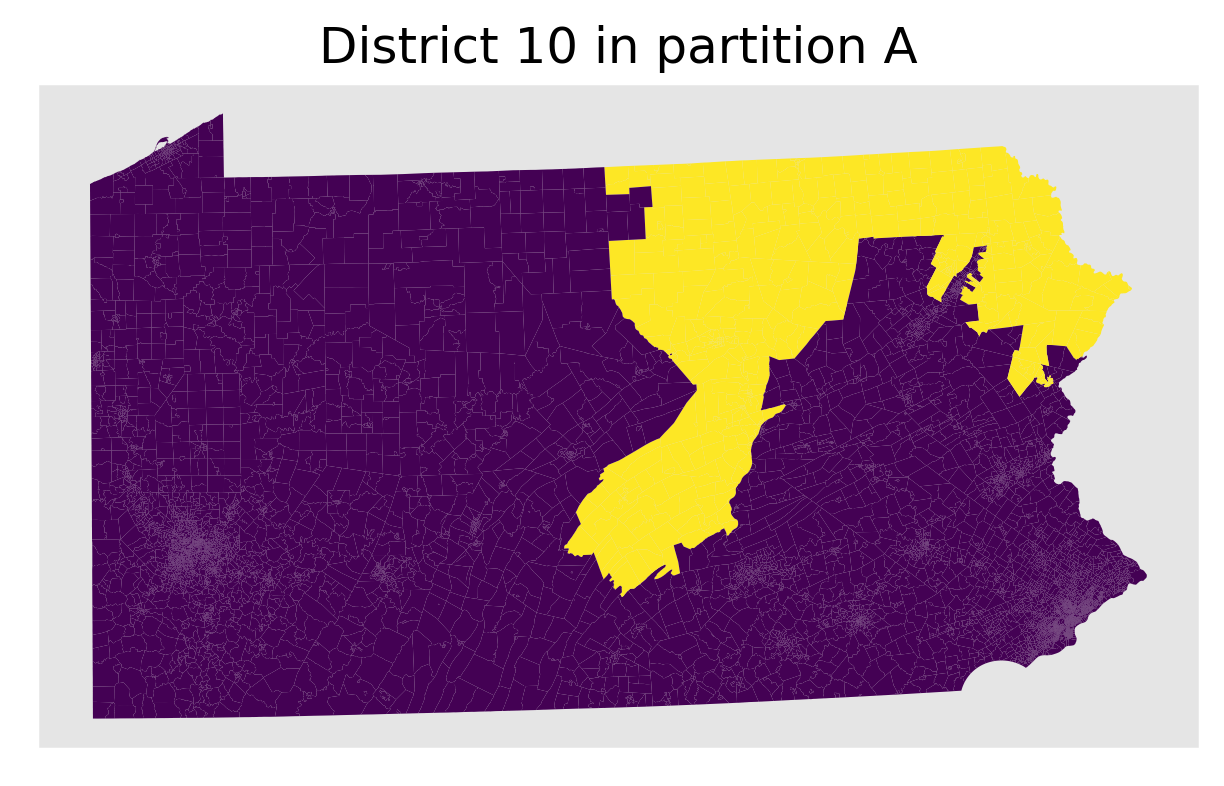

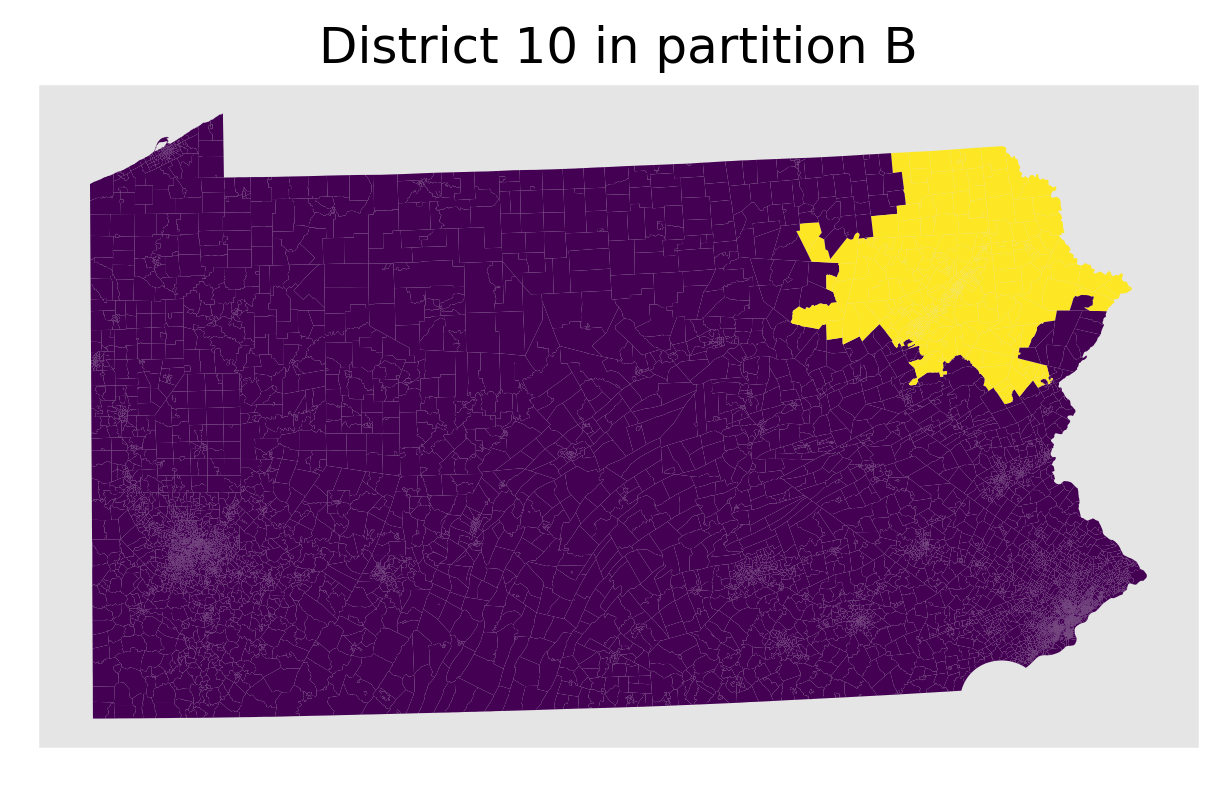

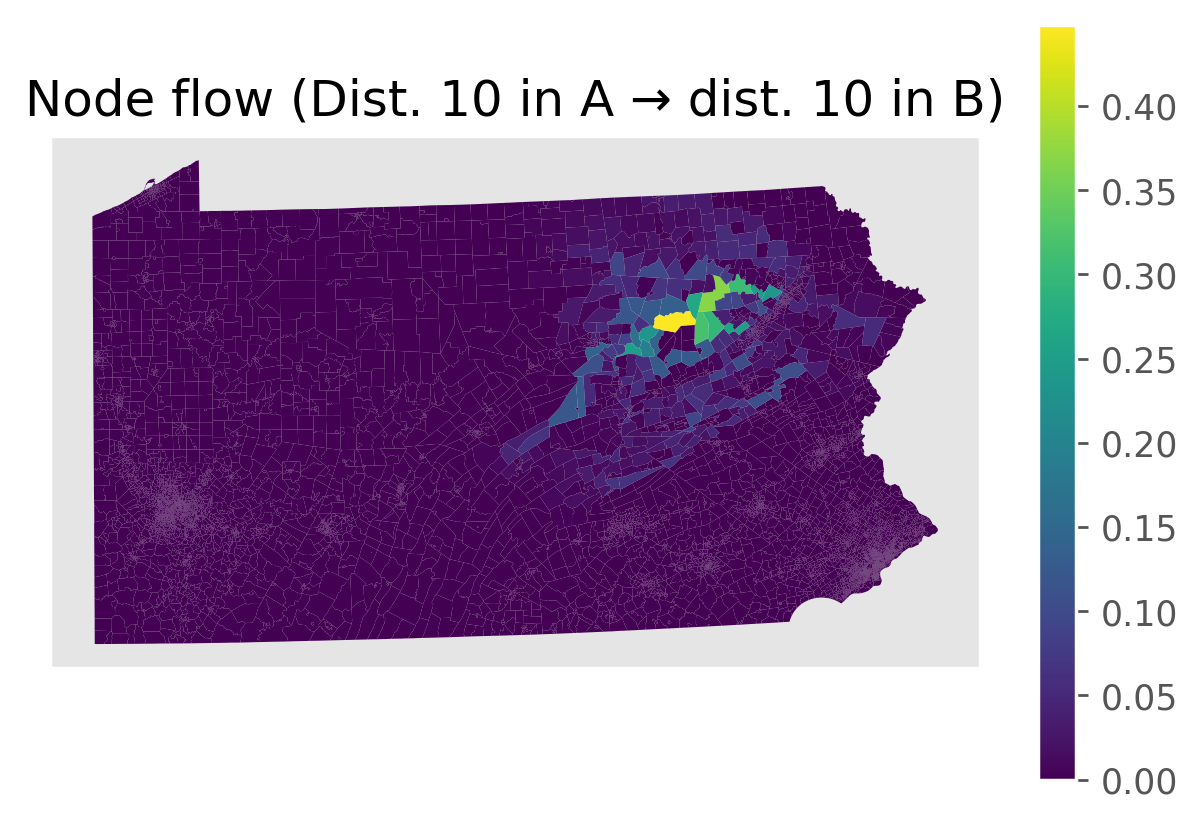

In [47]:
plot_flows(part_a, part_b, part_a_district, part_b_district)

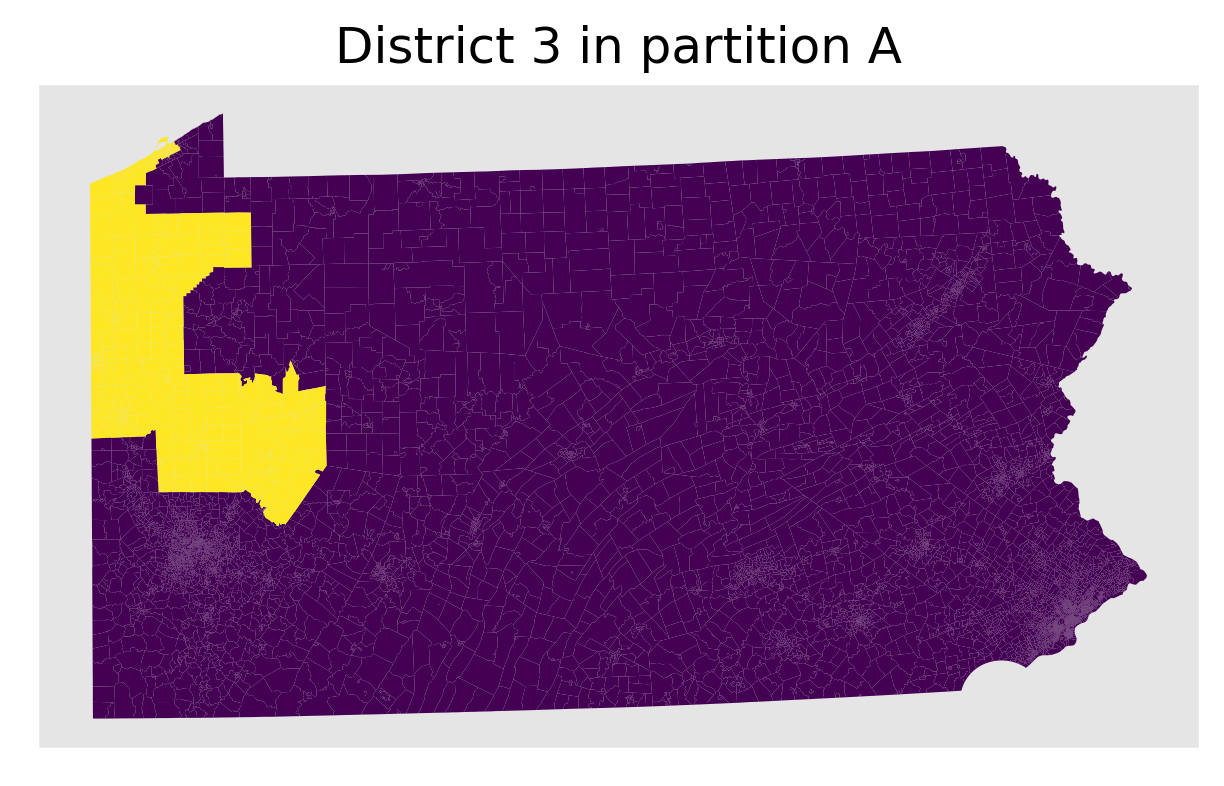

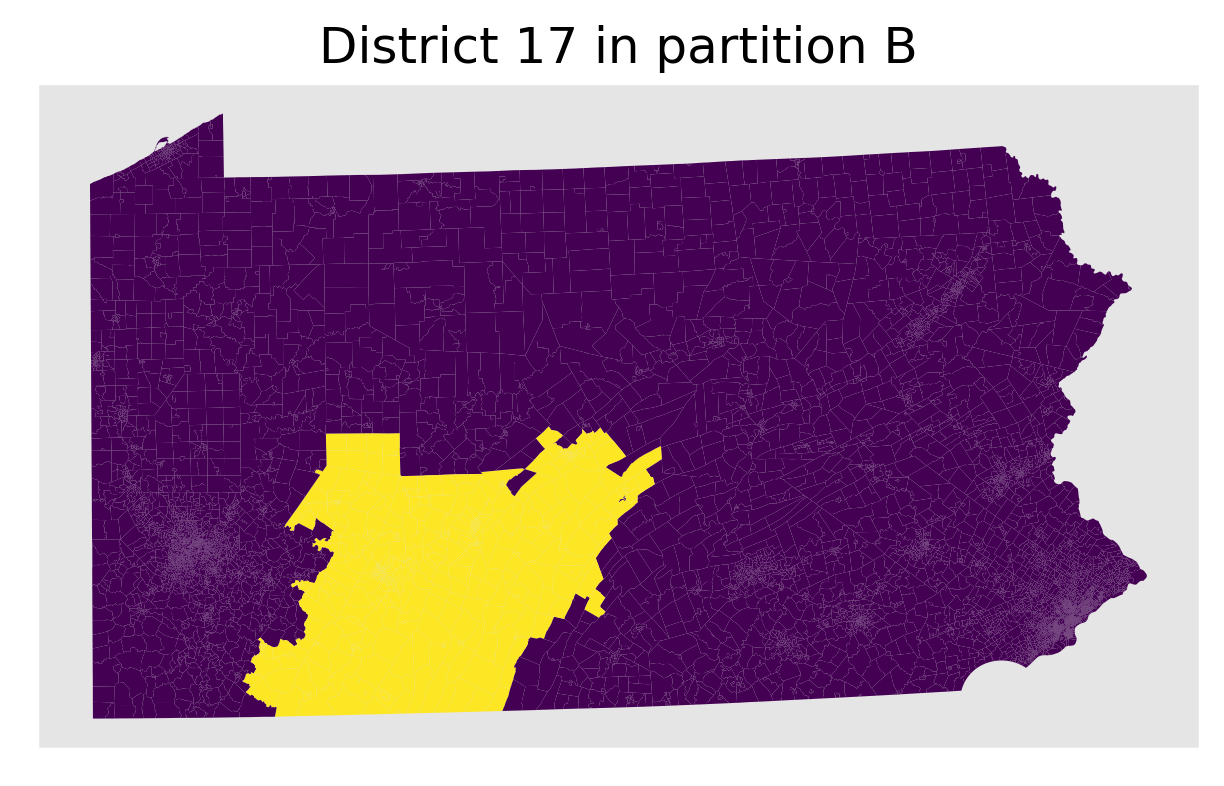

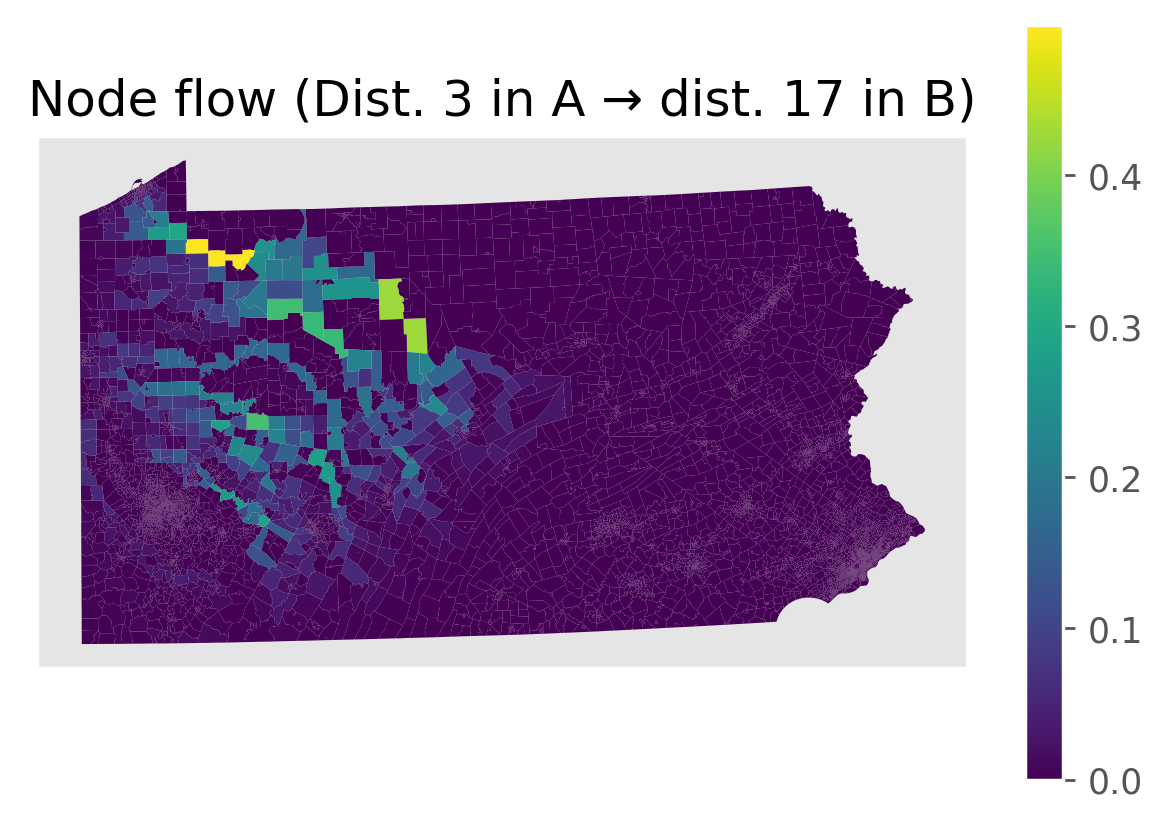

In [48]:
plot_flows(part_a, part_b, 3, 17)

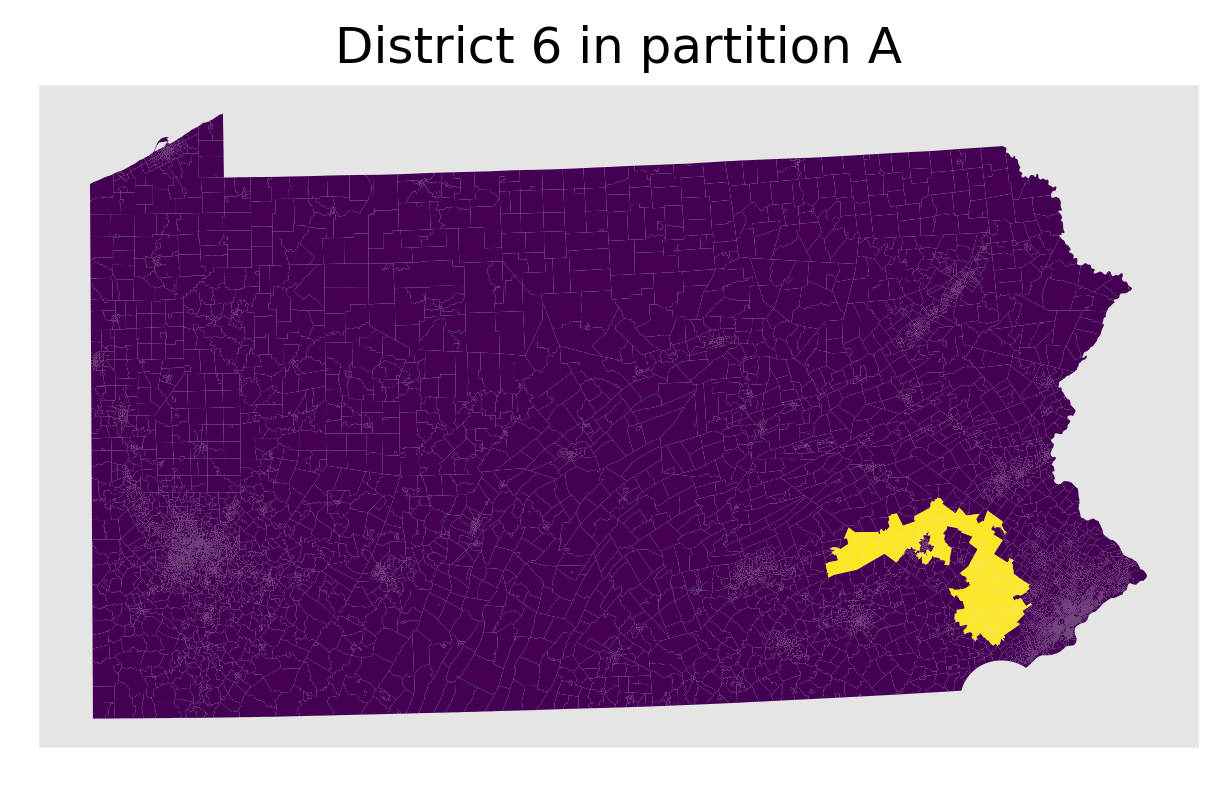

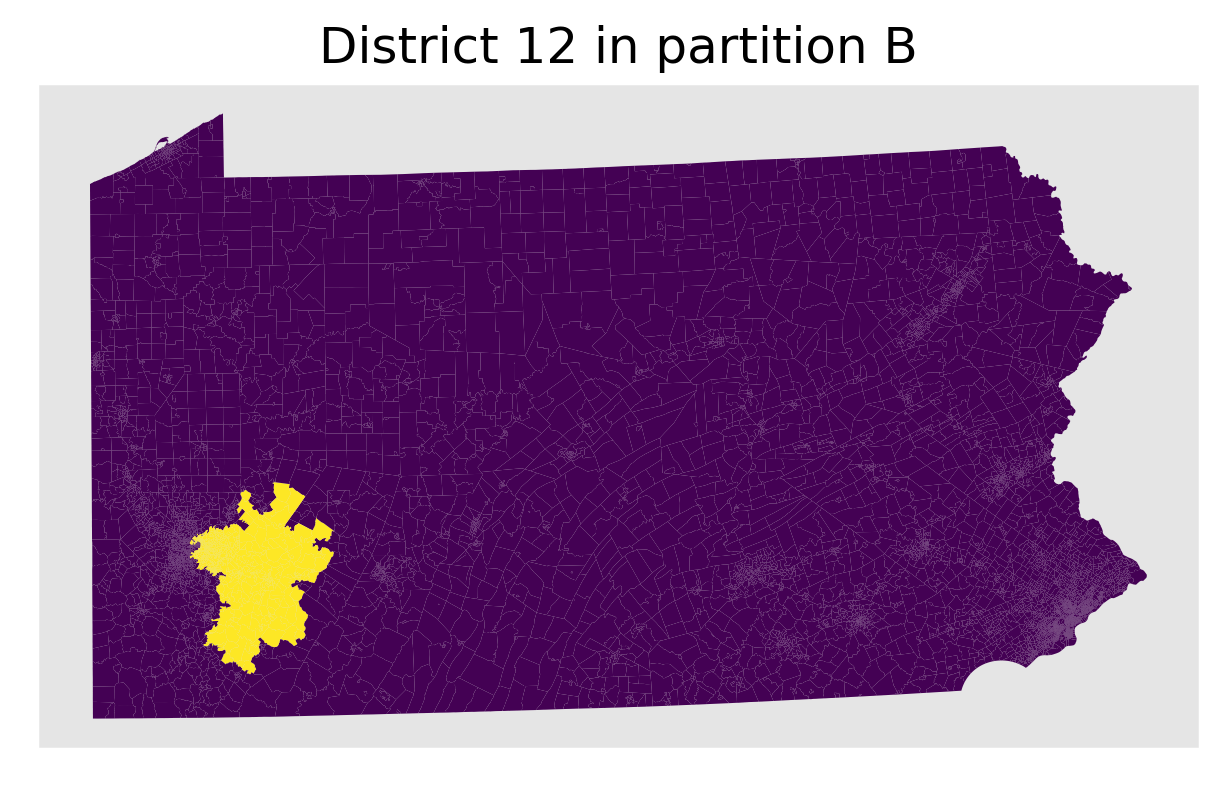

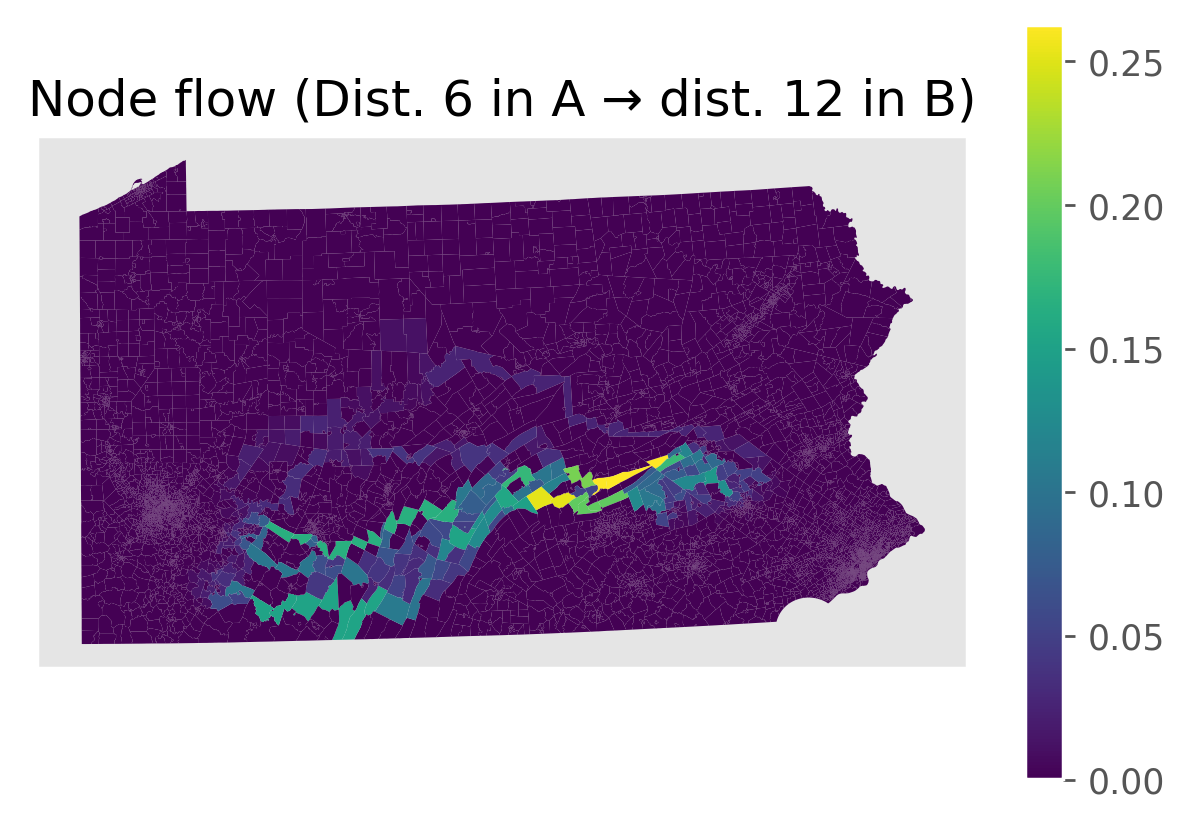

In [49]:
plot_flows(part_a, part_b, 6, 12)

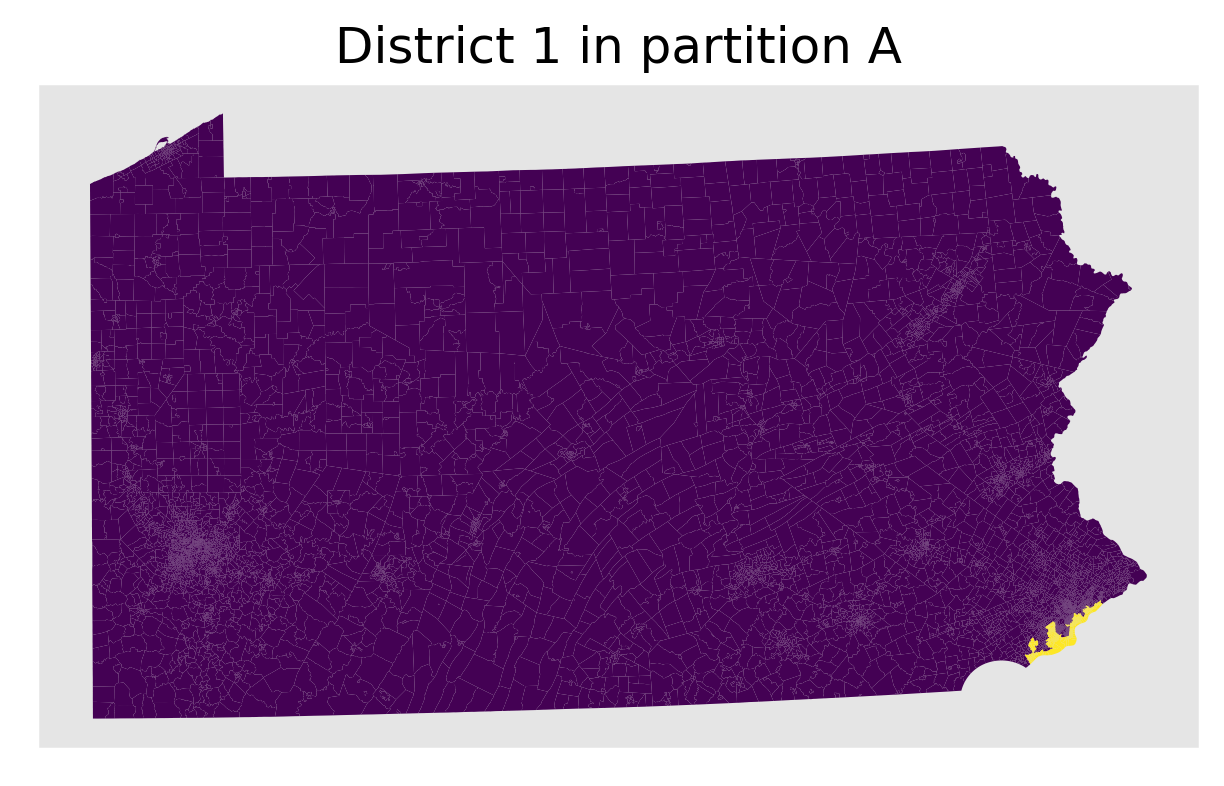

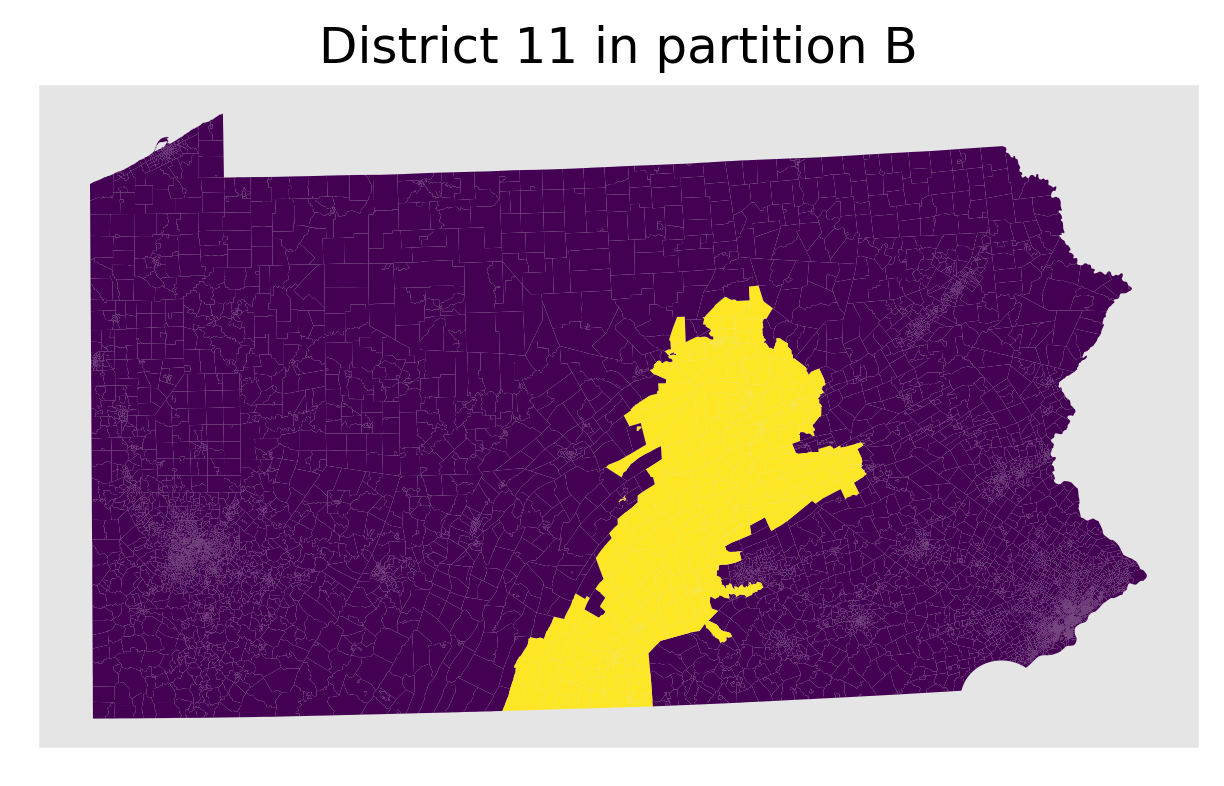

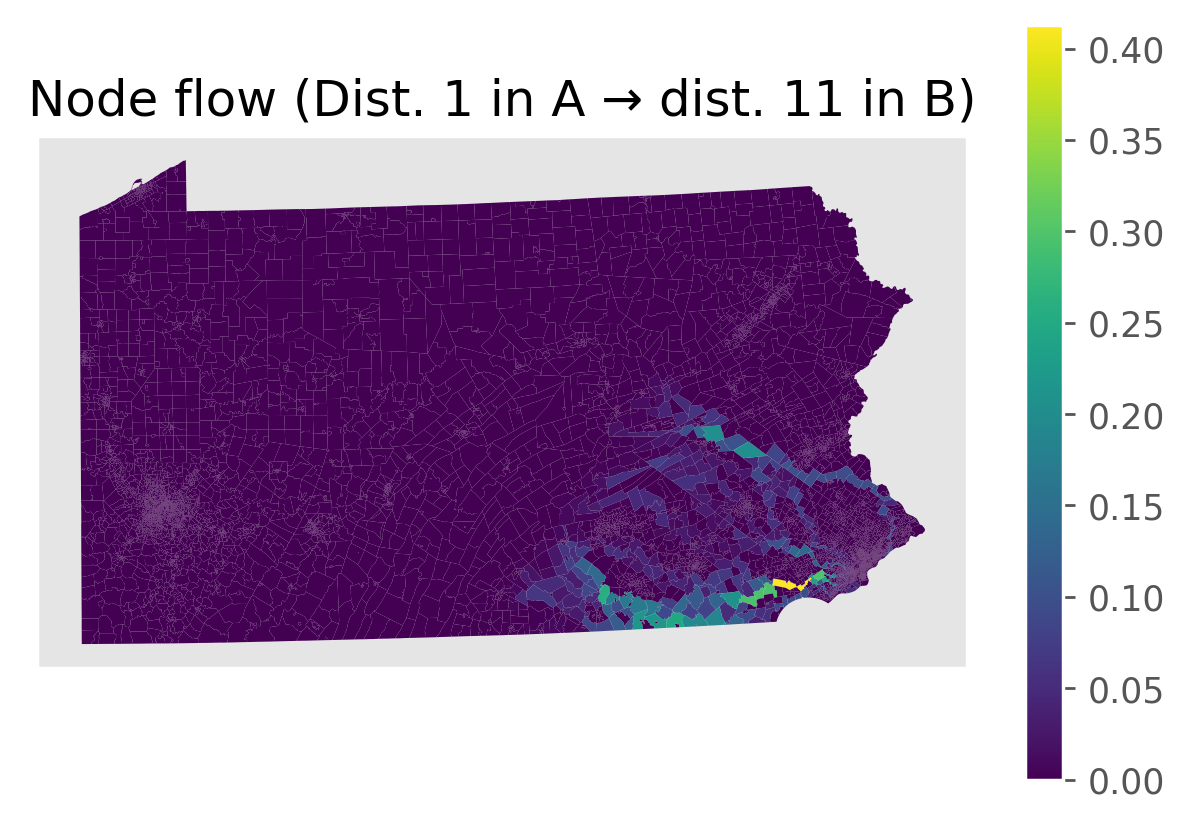

In [50]:
plot_flows(part_a, part_b, 1, 11)